# 付録A13: 社会的均衡理論（Social Balance Theory）

## 学習目標

この付録では、符号付きネットワークにおける社会的均衡理論について学びます。

- Heiderのバランス理論を理解する
- 符号付きネットワーク（正負のエッジ）を分析する
- バランスと不均衡の測定方法を学ぶ
- ネットワークの均衡化ダイナミクスをシミュレーションする

## セットアップ

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import defaultdict
from itertools import combinations
import japanize_matplotlib

# 日本語フォント設定
plt.rcParams['font.sans-serif'] = ['IPAexGothic'] + plt.rcParams['font.sans-serif']
plt.rcParams['figure.figsize'] = (10, 6)

# 再現性のための乱数シード
np.random.seed(42)
random.seed(42)

## A13.1 Heiderのバランス理論

### 理論の背景

Fritz Heider (1946) は、人間関係における認知的一貫性を研究し、**バランス理論**を提唱しました。

### 基本概念

3者間（トライアド）の関係において：
- **正の関係 (+)**: 友情、好意、同盟
- **負の関係 (-)**: 敵対、嫌悪、対立

### バランスの原則

**「敵の敵は味方」「味方の味方は味方」**

トライアドは、3つのエッジの積が正（+）のときにバランスしています：

| パターン | エッジの符号 | 積 | バランス |
|----------|-------------|-----|----------|
| +++ | (+)(+)(+) | + | バランス |
| ++- | (+)(+)(-) | - | 不均衡 |
| +-- | (+)(-)(-)  | + | バランス |
| --- | (-)(-)(-) | - | 不均衡 |

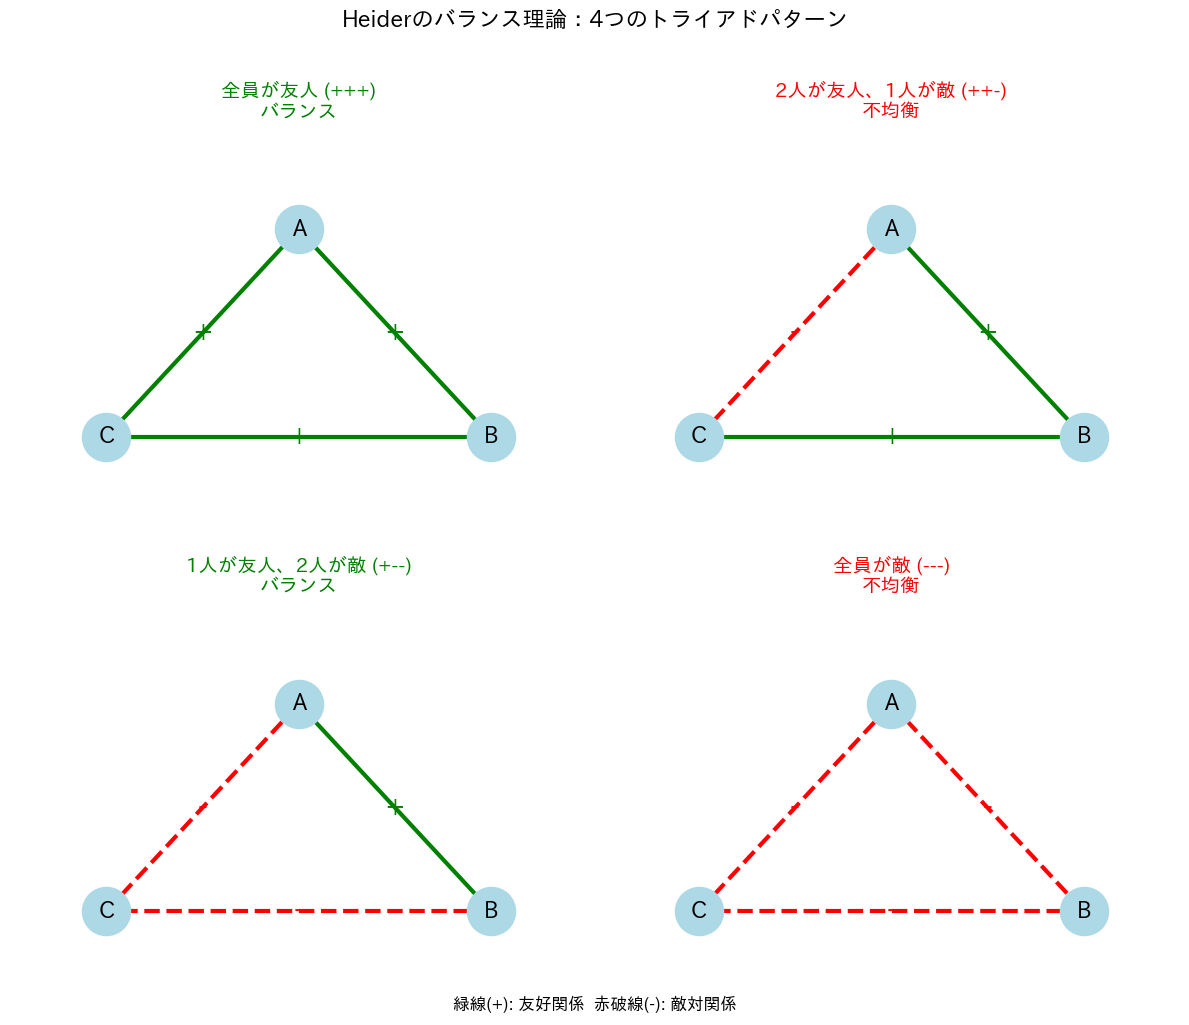

バランス理論の解釈:
  +++: 3人全員が友人 → 安定（バランス）
  ++-: 2人が友人だが、もう1人との関係が複雑 → 不安定（不均衡）
  +--: 2人が共通の敵を持つ → 安定（敵の敵は味方）
  ---: 3人全員が敵 → 不安定（連合形成の圧力）


In [2]:
def draw_signed_triad(ax, signs, title):
    """
    符号付きトライアドを描画
    signs: [AB, BC, CA] の符号リスト（1 or -1）
    """
    G = nx.Graph()
    G.add_nodes_from(['A', 'B', 'C'])
    
    edges = [('A', 'B'), ('B', 'C'), ('C', 'A')]
    for edge, sign in zip(edges, signs):
        G.add_edge(*edge, sign=sign)
    
    pos = {'A': (0, 1), 'B': (1, 0), 'C': (-1, 0)}
    
    # ノードを描画
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color='lightblue',
                           node_size=1200)
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=16)
    
    # エッジを符号に応じて色分け
    for edge, sign in zip(edges, signs):
        color = 'green' if sign > 0 else 'red'
        style = '-' if sign > 0 else '--'
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=[edge],
                               edge_color=color, width=3, style=style)
        
        # 符号ラベル
        mid_x = (pos[edge[0]][0] + pos[edge[1]][0]) / 2
        mid_y = (pos[edge[0]][1] + pos[edge[1]][1]) / 2
        label = '+' if sign > 0 else '-'
        ax.text(mid_x, mid_y, label, fontsize=20, ha='center', va='center',
               color=color, fontweight='bold')
    
    # バランス判定
    product = signs[0] * signs[1] * signs[2]
    balance_text = 'バランス' if product > 0 else '不均衡'
    balance_color = 'green' if product > 0 else 'red'
    
    ax.set_title(f'{title}\n{balance_text}', fontsize=14, color=balance_color)
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-0.5, 1.5)
    ax.axis('off')

# 4つのトライアドパターンを表示
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

patterns = [
    ([1, 1, 1], '全員が友人 (+++)'),
    ([1, 1, -1], '2人が友人、1人が敵 (++-)'),
    ([1, -1, -1], '1人が友人、2人が敵 (+--)'),
    ([-1, -1, -1], '全員が敵 (---)'),
]

for ax, (signs, title) in zip(axes, patterns):
    draw_signed_triad(ax, signs, title)

# 凡例
fig.text(0.5, 0.02, '緑線(+): 友好関係  赤破線(-): 敵対関係', 
         ha='center', fontsize=12)

plt.suptitle('Heiderのバランス理論：4つのトライアドパターン', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("バランス理論の解釈:")
print("  +++: 3人全員が友人 → 安定（バランス）")
print("  ++-: 2人が友人だが、もう1人との関係が複雑 → 不安定（不均衡）")
print("  +--: 2人が共通の敵を持つ → 安定（敵の敵は味方）")
print("  ---: 3人全員が敵 → 不安定（連合形成の圧力）")

## A13.2 符号付きネットワーク

### 符号付きグラフの作成と分析

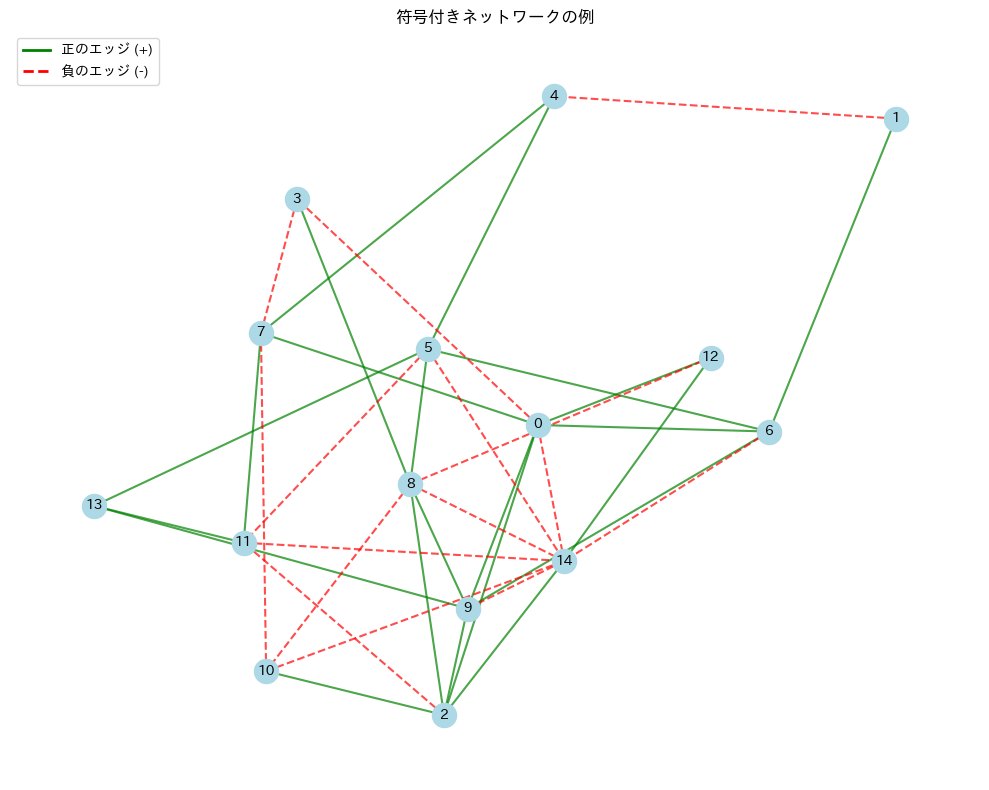

ネットワーク統計:
  ノード数: 15
  エッジ数: 37
  正のエッジ: 22 (59.5%)
  負のエッジ: 15 (40.5%)


In [3]:
def create_signed_network(n, p_edge=0.3, p_positive=0.6, seed=None):
    """
    ランダムな符号付きネットワークを生成
    
    Parameters:
    -----------
    n : int
        ノード数
    p_edge : float
        エッジの存在確率
    p_positive : float
        エッジが正である確率
    """
    if seed is not None:
        random.seed(seed)
    
    G = nx.Graph()
    G.add_nodes_from(range(n))
    
    for i in range(n):
        for j in range(i + 1, n):
            if random.random() < p_edge:
                sign = 1 if random.random() < p_positive else -1
                G.add_edge(i, j, sign=sign)
    
    return G

def draw_signed_network(G, ax=None, title=''):
    """
    符号付きネットワークを描画
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    pos = nx.spring_layout(G, seed=42)
    
    # ノードを描画
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color='lightblue',
                           node_size=300)
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=10)
    
    # 正のエッジ
    positive_edges = [(u, v) for u, v, d in G.edges(data=True) if d['sign'] > 0]
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=positive_edges,
                           edge_color='green', width=1.5, alpha=0.7)
    
    # 負のエッジ
    negative_edges = [(u, v) for u, v, d in G.edges(data=True) if d['sign'] < 0]
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=negative_edges,
                           edge_color='red', width=1.5, style='--', alpha=0.7)
    
    ax.set_title(title, fontsize=12)
    ax.axis('off')
    
    return ax

# 符号付きネットワークの例
G_signed = create_signed_network(15, p_edge=0.3, p_positive=0.6, seed=42)

fig, ax = plt.subplots(figsize=(10, 8))
draw_signed_network(G_signed, ax, '符号付きネットワークの例')

# 凡例
ax.plot([], [], 'g-', linewidth=2, label='正のエッジ (+)')
ax.plot([], [], 'r--', linewidth=2, label='負のエッジ (-)')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

n_positive = len([e for e in G_signed.edges(data=True) if e[2]['sign'] > 0])
n_negative = len([e for e in G_signed.edges(data=True) if e[2]['sign'] < 0])

print(f"ネットワーク統計:")
print(f"  ノード数: {G_signed.number_of_nodes()}")
print(f"  エッジ数: {G_signed.number_of_edges()}")
print(f"  正のエッジ: {n_positive} ({n_positive/G_signed.number_of_edges()*100:.1f}%)")
print(f"  負のエッジ: {n_negative} ({n_negative/G_signed.number_of_edges()*100:.1f}%)")

## A13.3 バランスの測定

### 三角形のバランス比率

ネットワーク内のすべての三角形について、バランスしているものの割合を計算します。

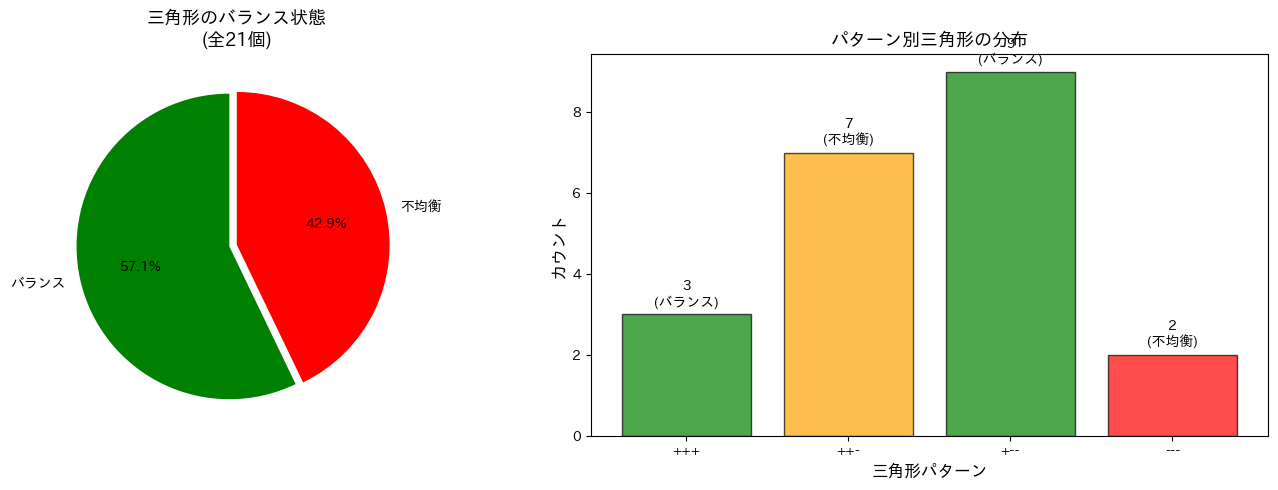

バランス分析結果:
  バランスした三角形: 12
  不均衡な三角形: 9
  バランス比率: 0.571

パターン別:
  +++: 3
  ++-: 7
  +--: 9
  ---: 2


In [4]:
def count_triangles_by_balance(G):
    """
    三角形をバランス/不均衡で分類してカウント
    """
    balanced = 0
    unbalanced = 0
    triangle_details = {'+++': 0, '++-': 0, '+--': 0, '---': 0}
    
    # すべての三角形を列挙
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                if G.has_edge(n1, n2):
                    # 三角形を発見
                    sign1 = G[node][n1]['sign']
                    sign2 = G[node][n2]['sign']
                    sign3 = G[n1][n2]['sign']
                    
                    product = sign1 * sign2 * sign3
                    
                    # パターンを分類
                    n_positive = sum(1 for s in [sign1, sign2, sign3] if s > 0)
                    if n_positive == 3:
                        triangle_details['+++'] += 1
                    elif n_positive == 2:
                        triangle_details['++-'] += 1
                    elif n_positive == 1:
                        triangle_details['+--'] += 1
                    else:
                        triangle_details['---'] += 1
                    
                    if product > 0:
                        balanced += 1
                    else:
                        unbalanced += 1
    
    # 各三角形が3回カウントされるので3で割る
    balanced //= 3
    unbalanced //= 3
    for key in triangle_details:
        triangle_details[key] //= 3
    
    return balanced, unbalanced, triangle_details

def calculate_balance_ratio(G):
    """
    バランス比率を計算
    """
    balanced, unbalanced, _ = count_triangles_by_balance(G)
    total = balanced + unbalanced
    if total == 0:
        return 0
    return balanced / total

# サンプルネットワークのバランス分析
balanced, unbalanced, details = count_triangles_by_balance(G_signed)
balance_ratio = calculate_balance_ratio(G_signed)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# バランス/不均衡の円グラフ
if balanced + unbalanced > 0:
    axes[0].pie([balanced, unbalanced], labels=['バランス', '不均衡'],
                colors=['green', 'red'], autopct='%1.1f%%',
                startangle=90, explode=[0.05, 0])
    axes[0].set_title(f'三角形のバランス状態\n(全{balanced + unbalanced}個)', fontsize=13)
else:
    axes[0].text(0.5, 0.5, '三角形なし', ha='center', va='center', fontsize=14)
    axes[0].set_title('三角形のバランス状態', fontsize=13)

# パターン別の棒グラフ
patterns = ['+++', '++-', '+--', '---']
counts = [details[p] for p in patterns]
colors = ['green', 'orange', 'green', 'red']  # バランス=緑、不均衡=赤/オレンジ

bars = axes[1].bar(patterns, counts, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('三角形パターン', fontsize=12)
axes[1].set_ylabel('カウント', fontsize=12)
axes[1].set_title('パターン別三角形の分布', fontsize=13)

# バランス/不均衡のラベル
for i, (bar, pattern) in enumerate(zip(bars, patterns)):
    is_balanced = pattern in ['+++', '+--']
    label = 'バランス' if is_balanced else '不均衡'
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                f'{counts[i]}\n({label})', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f"バランス分析結果:")
print(f"  バランスした三角形: {balanced}")
print(f"  不均衡な三角形: {unbalanced}")
print(f"  バランス比率: {balance_ratio:.3f}")
print(f"\nパターン別:")
for pattern, count in details.items():
    print(f"  {pattern}: {count}")

## A13.4 構造的バランス定理

### Cartwright-Harary の定理

完全にバランスしたネットワークは、2つの対立するグループに分割できます：
- グループ内はすべて正の関係
- グループ間はすべて負の関係

これは「弱い構造的バランス」とも呼ばれます。

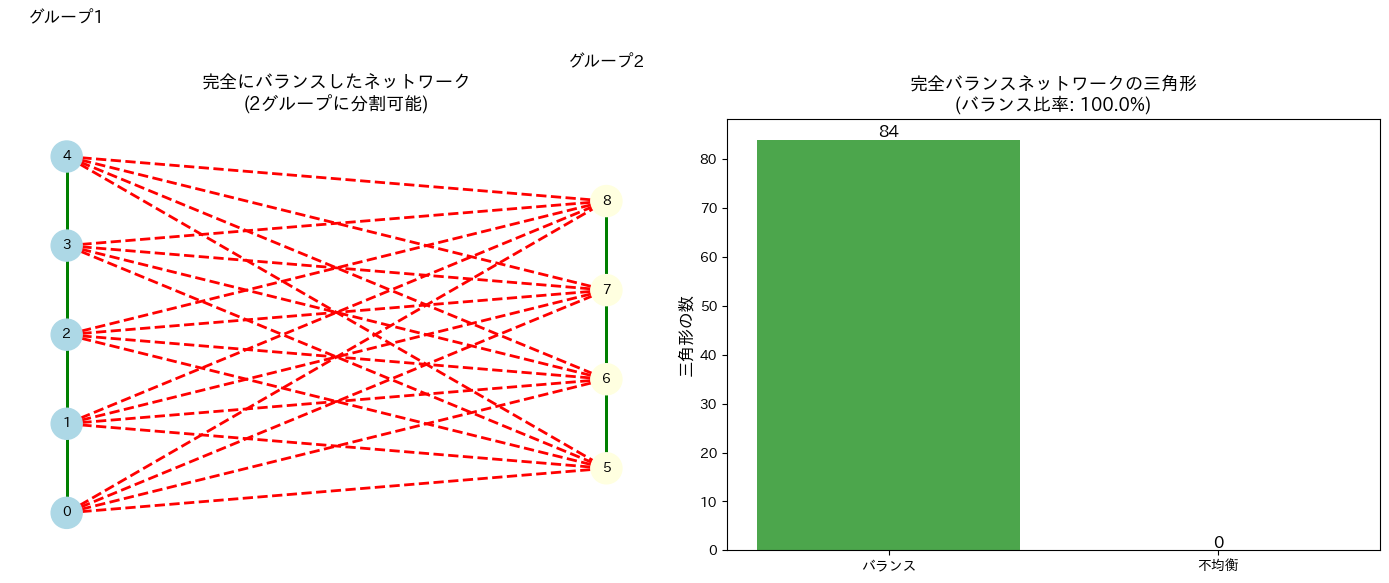

構造的バランス定理:
  完全にバランスしたネットワークは、2つの対立するグループに分割できる
  - グループ内: すべて正の関係（友好）
  - グループ間: すべて負の関係（敵対）


In [5]:
def create_perfectly_balanced_network(group1_size, group2_size):
    """
    完全にバランスしたネットワークを生成
    2つのグループに分かれ、グループ内は+、グループ間は-
    """
    G = nx.Graph()
    
    # グループ1のノード
    group1 = list(range(group1_size))
    # グループ2のノード
    group2 = list(range(group1_size, group1_size + group2_size))
    
    G.add_nodes_from(group1, group=0)
    G.add_nodes_from(group2, group=1)
    
    # グループ内のエッジ（正）
    for i, n1 in enumerate(group1):
        for n2 in group1[i+1:]:
            G.add_edge(n1, n2, sign=1)
    
    for i, n1 in enumerate(group2):
        for n2 in group2[i+1:]:
            G.add_edge(n1, n2, sign=1)
    
    # グループ間のエッジ（負）
    for n1 in group1:
        for n2 in group2:
            G.add_edge(n1, n2, sign=-1)
    
    return G, group1, group2

# 完全にバランスしたネットワーク
G_perfect, group1, group2 = create_perfectly_balanced_network(5, 4)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 完全バランスネットワーク
pos = {}
for i, n in enumerate(group1):
    pos[n] = (-1, i - len(group1)/2)
for i, n in enumerate(group2):
    pos[n] = (1, i - len(group2)/2)

# ノードをグループで色分け
colors = ['lightblue' if n in group1 else 'lightyellow' for n in G_perfect.nodes()]
nx.draw_networkx_nodes(G_perfect, pos, ax=axes[0], node_color=colors, node_size=500)
nx.draw_networkx_labels(G_perfect, pos, ax=axes[0], font_size=10)

# エッジ
positive_edges = [(u, v) for u, v, d in G_perfect.edges(data=True) if d['sign'] > 0]
negative_edges = [(u, v) for u, v, d in G_perfect.edges(data=True) if d['sign'] < 0]

nx.draw_networkx_edges(G_perfect, pos, ax=axes[0], edgelist=positive_edges,
                       edge_color='green', width=2)
nx.draw_networkx_edges(G_perfect, pos, ax=axes[0], edgelist=negative_edges,
                       edge_color='red', width=2, style='--')

axes[0].set_title('完全にバランスしたネットワーク\n(2グループに分割可能)', fontsize=13)

# グループラベル
axes[0].text(-1, len(group1)/2 + 0.5, 'グループ1', ha='center', fontsize=12, fontweight='bold')
axes[0].text(1, len(group2)/2 + 0.5, 'グループ2', ha='center', fontsize=12, fontweight='bold')
axes[0].axis('off')

# バランス分析
balanced, unbalanced, details = count_triangles_by_balance(G_perfect)
total_triangles = balanced + unbalanced

axes[1].bar(['バランス', '不均衡'], [balanced, unbalanced],
            color=['green', 'red'], alpha=0.7)
axes[1].set_ylabel('三角形の数', fontsize=12)
axes[1].set_title(f'完全バランスネットワークの三角形\n(バランス比率: {balanced/total_triangles:.1%})', fontsize=13)

for i, val in enumerate([balanced, unbalanced]):
    axes[1].text(i, val + 0.5, str(val), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

print("構造的バランス定理:")
print("  完全にバランスしたネットワークは、2つの対立するグループに分割できる")
print("  - グループ内: すべて正の関係（友好）")
print("  - グループ間: すべて負の関係（敵対）")

## A13.5 バランス化ダイナミクス

### ネットワークの均衡化過程

不均衡なネットワークは、時間とともにバランスに向かう傾向があります。

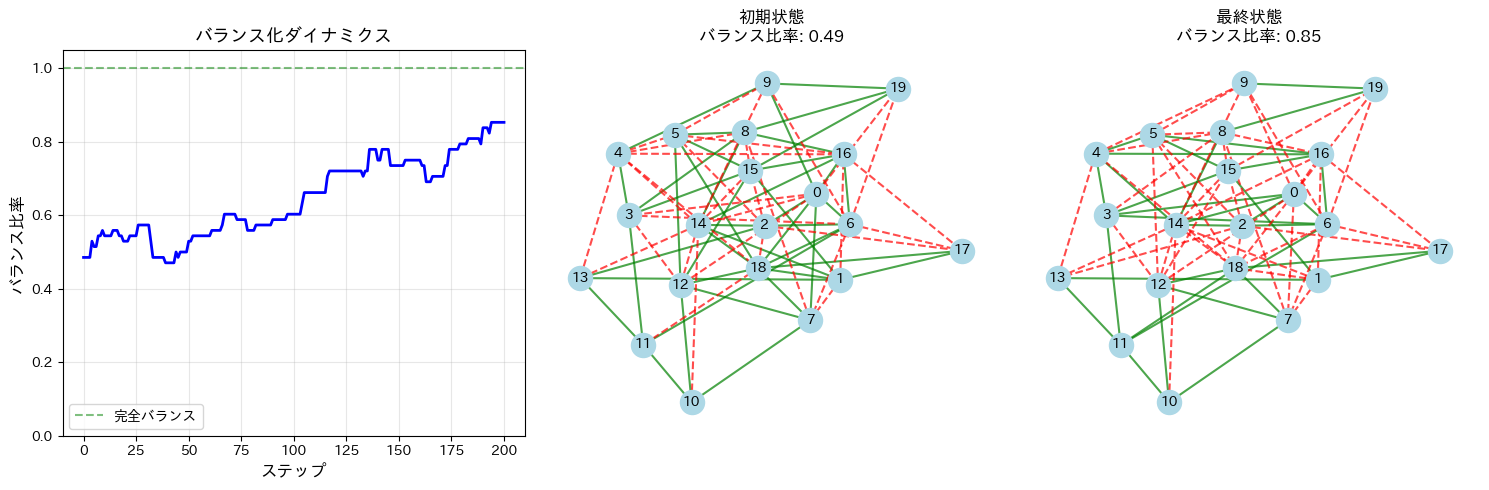

バランス化の結果:
  初期バランス比率: 0.485
  最終バランス比率: 0.853


In [6]:
def balance_dynamics(G, max_steps=100, p_flip=0.1):
    """
    バランス化ダイナミクスのシミュレーション
    不均衡な三角形のエッジを確率的に反転
    """
    G = G.copy()
    history = [calculate_balance_ratio(G)]
    
    for step in range(max_steps):
        # 不均衡な三角形を見つける
        unbalanced_triangles = []
        
        for node in G.nodes():
            neighbors = list(G.neighbors(node))
            for i, n1 in enumerate(neighbors):
                for n2 in neighbors[i+1:]:
                    if G.has_edge(n1, n2):
                        sign1 = G[node][n1]['sign']
                        sign2 = G[node][n2]['sign']
                        sign3 = G[n1][n2]['sign']
                        
                        if sign1 * sign2 * sign3 < 0:
                            unbalanced_triangles.append((node, n1, n2))
        
        if not unbalanced_triangles:
            # 完全にバランス
            history.extend([1.0] * (max_steps - step))
            break
        
        # ランダムに不均衡な三角形を選び、エッジを反転
        if random.random() < p_flip:
            triangle = random.choice(unbalanced_triangles)
            edges = [(triangle[0], triangle[1]),
                    (triangle[0], triangle[2]),
                    (triangle[1], triangle[2])]
            edge_to_flip = random.choice(edges)
            
            G[edge_to_flip[0]][edge_to_flip[1]]['sign'] *= -1
        
        history.append(calculate_balance_ratio(G))
    
    return G, history

# 初期ネットワーク（不均衡が多い）
G_initial = create_signed_network(20, p_edge=0.4, p_positive=0.5, seed=42)

# ダイナミクスのシミュレーション
G_final, history = balance_dynamics(G_initial, max_steps=200, p_flip=0.3)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# バランス比率の推移
axes[0].plot(history, 'b-', linewidth=2)
axes[0].set_xlabel('ステップ', fontsize=12)
axes[0].set_ylabel('バランス比率', fontsize=12)
axes[0].set_title('バランス化ダイナミクス', fontsize=13)
axes[0].set_ylim(0, 1.05)
axes[0].axhline(y=1.0, color='green', linestyle='--', alpha=0.5, label='完全バランス')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 初期状態
draw_signed_network(G_initial, axes[1], '初期状態')
initial_ratio = calculate_balance_ratio(G_initial)
axes[1].set_title(f'初期状態\nバランス比率: {initial_ratio:.2f}', fontsize=12)

# 最終状態
draw_signed_network(G_final, axes[2], '最終状態')
final_ratio = calculate_balance_ratio(G_final)
axes[2].set_title(f'最終状態\nバランス比率: {final_ratio:.2f}', fontsize=12)

plt.tight_layout()
plt.show()

print(f"バランス化の結果:")
print(f"  初期バランス比率: {initial_ratio:.3f}")
print(f"  最終バランス比率: {final_ratio:.3f}")

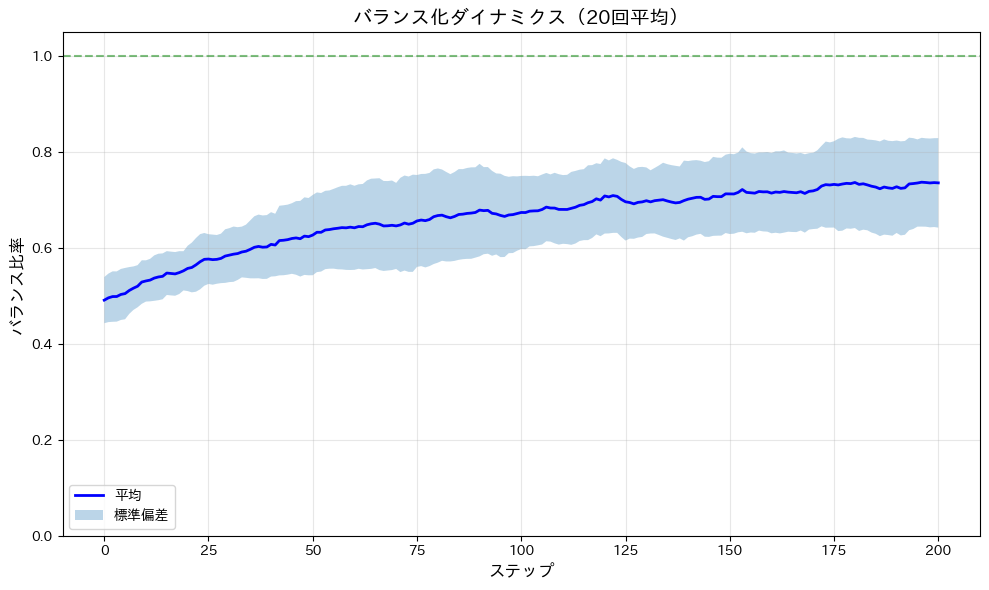

観察結果:
  不均衡なネットワークは時間とともにバランスに向かう
  これは社会的圧力による関係の調整を反映


In [7]:
# 複数回のシミュレーションで傾向を確認
n_trials = 20
all_histories = []

for trial in range(n_trials):
    G_init = create_signed_network(20, p_edge=0.4, p_positive=0.5, seed=trial)
    _, history = balance_dynamics(G_init, max_steps=200, p_flip=0.3)
    all_histories.append(history)

# 平均と標準偏差
max_len = max(len(h) for h in all_histories)
padded = [h + [h[-1]] * (max_len - len(h)) for h in all_histories]
mean_history = np.mean(padded, axis=0)
std_history = np.std(padded, axis=0)

fig, ax = plt.subplots(figsize=(10, 6))

steps = range(len(mean_history))
ax.plot(steps, mean_history, 'b-', linewidth=2, label='平均')
ax.fill_between(steps,
                mean_history - std_history,
                mean_history + std_history,
                alpha=0.3, label='標準偏差')

ax.set_xlabel('ステップ', fontsize=12)
ax.set_ylabel('バランス比率', fontsize=12)
ax.set_title(f'バランス化ダイナミクス（{n_trials}回平均）', fontsize=14)
ax.set_ylim(0, 1.05)
ax.axhline(y=1.0, color='green', linestyle='--', alpha=0.5)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("観察結果:")
print("  不均衡なネットワークは時間とともにバランスに向かう")
print("  これは社会的圧力による関係の調整を反映")

## A13.6 フラストレーション指標

### フラストレーションの定義

ネットワークを完全にバランスさせるために反転が必要なエッジの最小数をフラストレーション指標と呼びます。

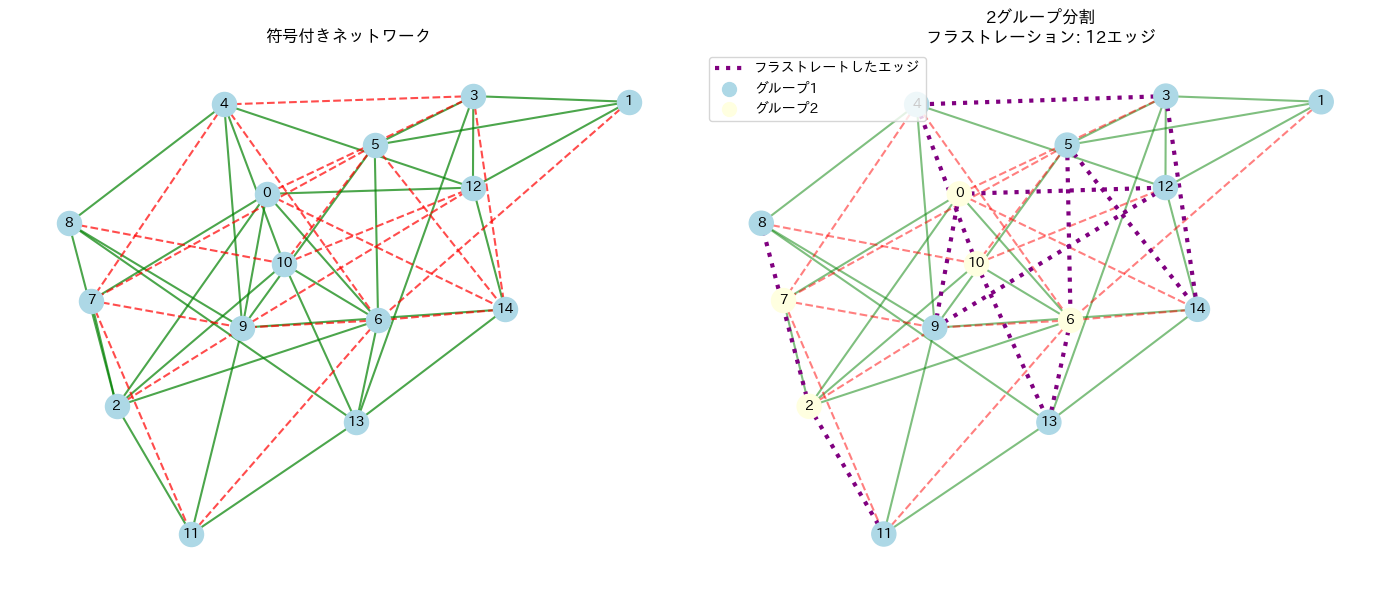

フラストレーション分析:
  総エッジ数: 51
  フラストレーション: 12
  フラストレーション比率: 0.235

  グループ1: 10ノード
  グループ2: 5ノード


In [8]:
def estimate_frustration(G, n_attempts=100):
    """
    フラストレーション指標を推定
    ヒューリスティックに2グループ分割を探索
    """
    nodes = list(G.nodes())
    n = len(nodes)
    
    if n == 0:
        return 0, [], []
    
    best_frustration = float('inf')
    best_partition = None
    
    for _ in range(n_attempts):
        # ランダムに2グループに分割
        random.shuffle(nodes)
        split = random.randint(1, n - 1)
        group1 = set(nodes[:split])
        group2 = set(nodes[split:])
        
        # ローカルサーチで改善
        improved = True
        while improved:
            improved = False
            for node in nodes:
                current_group = group1 if node in group1 else group2
                other_group = group2 if node in group1 else group1
                
                # 現在のフラストレーション
                current_frust = 0
                for neighbor in G.neighbors(node):
                    sign = G[node][neighbor]['sign']
                    same_group = neighbor in current_group
                    if (sign > 0 and not same_group) or (sign < 0 and same_group):
                        current_frust += 1
                
                # 移動後のフラストレーション
                new_frust = 0
                for neighbor in G.neighbors(node):
                    sign = G[node][neighbor]['sign']
                    same_group = neighbor in other_group
                    if (sign > 0 and not same_group) or (sign < 0 and same_group):
                        new_frust += 1
                
                if new_frust < current_frust:
                    current_group.remove(node)
                    other_group.add(node)
                    improved = True
        
        # フラストレーションを計算
        frustration = 0
        for u, v, d in G.edges(data=True):
            sign = d['sign']
            same_group = (u in group1 and v in group1) or (u in group2 and v in group2)
            if (sign > 0 and not same_group) or (sign < 0 and same_group):
                frustration += 1
        
        if frustration < best_frustration:
            best_frustration = frustration
            best_partition = (list(group1), list(group2))
    
    return best_frustration, best_partition[0], best_partition[1]

# フラストレーション分析
G_test = create_signed_network(15, p_edge=0.5, p_positive=0.6, seed=42)
frustration, group1, group2 = estimate_frustration(G_test)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 元のネットワーク
draw_signed_network(G_test, axes[0], '符号付きネットワーク')

# 2グループ分割
pos = nx.spring_layout(G_test, seed=42)

# ノードをグループで色分け
colors = ['lightblue' if n in group1 else 'lightyellow' for n in G_test.nodes()]
nx.draw_networkx_nodes(G_test, pos, ax=axes[1], node_color=colors, node_size=300)
nx.draw_networkx_labels(G_test, pos, ax=axes[1], font_size=10)

# フラストレートしたエッジをハイライト
frustrated_edges = []
normal_positive = []
normal_negative = []

for u, v, d in G_test.edges(data=True):
    sign = d['sign']
    same_group = (u in group1 and v in group1) or (u in group2 and v in group2)
    is_frustrated = (sign > 0 and not same_group) or (sign < 0 and same_group)
    
    if is_frustrated:
        frustrated_edges.append((u, v))
    elif sign > 0:
        normal_positive.append((u, v))
    else:
        normal_negative.append((u, v))

nx.draw_networkx_edges(G_test, pos, ax=axes[1], edgelist=normal_positive,
                       edge_color='green', width=1.5, alpha=0.5)
nx.draw_networkx_edges(G_test, pos, ax=axes[1], edgelist=normal_negative,
                       edge_color='red', width=1.5, style='--', alpha=0.5)
nx.draw_networkx_edges(G_test, pos, ax=axes[1], edgelist=frustrated_edges,
                       edge_color='purple', width=3, style=':')

axes[1].set_title(f'2グループ分割\nフラストレーション: {frustration}エッジ', fontsize=12)
axes[1].axis('off')

# 凡例
axes[1].plot([], [], 'purple', linewidth=3, linestyle=':', label='フラストレートしたエッジ')
axes[1].scatter([], [], c='lightblue', s=100, label='グループ1')
axes[1].scatter([], [], c='lightyellow', s=100, label='グループ2')
axes[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

print(f"フラストレーション分析:")
print(f"  総エッジ数: {G_test.number_of_edges()}")
print(f"  フラストレーション: {frustration}")
print(f"  フラストレーション比率: {frustration / G_test.number_of_edges():.3f}")
print(f"\n  グループ1: {len(group1)}ノード")
print(f"  グループ2: {len(group2)}ノード")

## A13.7 実世界への応用

### 国際関係ネットワーク

社会的均衡理論は国際関係の分析にも適用されます。

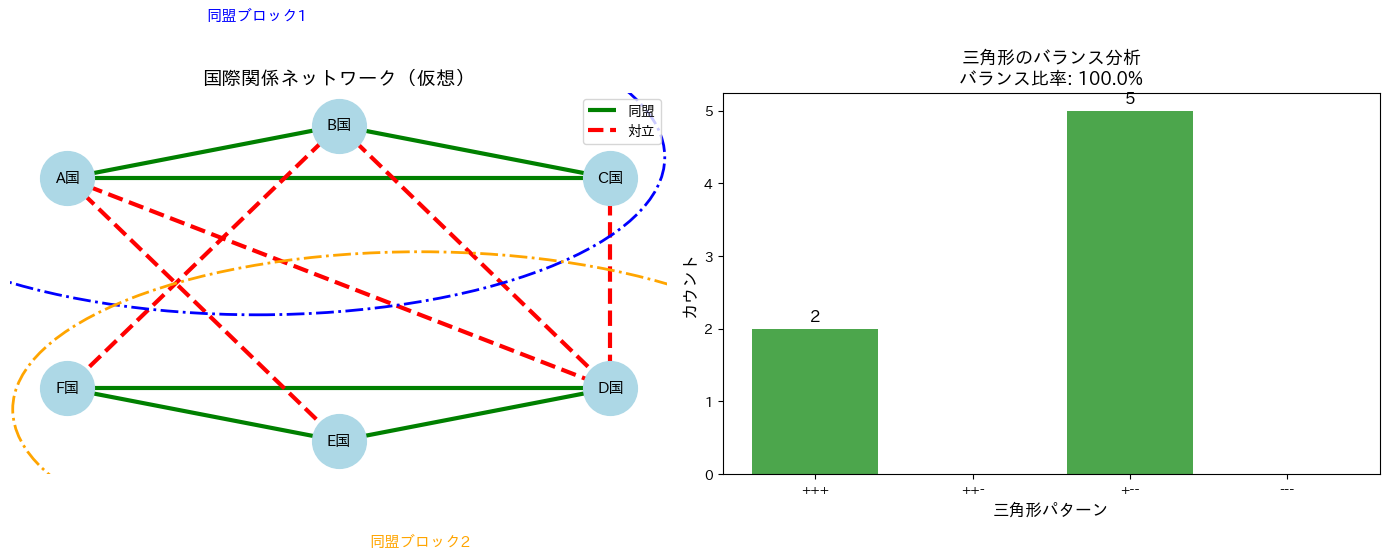

国際関係ネットワークの分析:
  バランス比率: 100.0%

パターン別:
  +++: 2 (バランス)
  +--: 5 (バランス)

解釈: 2つの対立するブロックが形成されている


In [9]:
# 仮想的な国際関係ネットワーク
def create_international_network():
    G = nx.Graph()
    
    # 国を追加（仮想的な例）
    countries = ['A国', 'B国', 'C国', 'D国', 'E国', 'F国']
    G.add_nodes_from(countries)
    
    # 関係を定義（+: 同盟、-: 対立）
    relations = [
        ('A国', 'B国', 1),   # 同盟
        ('A国', 'C国', 1),   # 同盟
        ('B国', 'C国', 1),   # 同盟
        ('A国', 'D国', -1),  # 対立
        ('B国', 'D国', -1),  # 対立
        ('C国', 'D国', -1),  # 対立
        ('D国', 'E国', 1),   # 同盟
        ('D国', 'F国', 1),   # 同盟
        ('E国', 'F国', 1),   # 同盟
        ('A国', 'E国', -1),  # 対立
        ('B国', 'F国', -1),  # 対立
    ]
    
    for u, v, sign in relations:
        G.add_edge(u, v, sign=sign)
    
    return G

G_intl = create_international_network()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ネットワーク可視化
pos = {
    'A国': (-1, 1), 'B国': (0, 1.5), 'C国': (1, 1),
    'D国': (1, -1), 'E国': (0, -1.5), 'F国': (-1, -1)
}

# ノードを描画
nx.draw_networkx_nodes(G_intl, pos, ax=axes[0], node_color='lightblue',
                       node_size=1500)
nx.draw_networkx_labels(G_intl, pos, ax=axes[0], font_size=11)

# エッジを描画
positive_edges = [(u, v) for u, v, d in G_intl.edges(data=True) if d['sign'] > 0]
negative_edges = [(u, v) for u, v, d in G_intl.edges(data=True) if d['sign'] < 0]

nx.draw_networkx_edges(G_intl, pos, ax=axes[0], edgelist=positive_edges,
                       edge_color='green', width=3, label='同盟')
nx.draw_networkx_edges(G_intl, pos, ax=axes[0], edgelist=negative_edges,
                       edge_color='red', width=3, style='--', label='対立')

axes[0].set_title('国際関係ネットワーク（仮想）', fontsize=14)
axes[0].legend(loc='upper right')
axes[0].axis('off')

# ブロック構造を強調
axes[0].add_patch(plt.Circle((-0.3, 1.2), 1.5, fill=False, 
                              color='blue', linewidth=2, linestyle='-.'))
axes[0].add_patch(plt.Circle((0.3, -1.2), 1.5, fill=False,
                              color='orange', linewidth=2, linestyle='-.'))
axes[0].text(-0.3, 2.5, '同盟ブロック1', ha='center', fontsize=11, color='blue')
axes[0].text(0.3, -2.5, '同盟ブロック2', ha='center', fontsize=11, color='orange')

# バランス分析
balanced, unbalanced, details = count_triangles_by_balance(G_intl)
balance_ratio = calculate_balance_ratio(G_intl)

patterns = ['+++', '++-', '+--', '---']
counts = [details[p] for p in patterns]
colors = ['green', 'red', 'green', 'red']

bars = axes[1].bar(patterns, counts, color=colors, alpha=0.7)
axes[1].set_xlabel('三角形パターン', fontsize=12)
axes[1].set_ylabel('カウント', fontsize=12)
axes[1].set_title(f'三角形のバランス分析\nバランス比率: {balance_ratio:.1%}', fontsize=13)

for bar, count in zip(bars, counts):
    if count > 0:
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    str(count), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

print(f"国際関係ネットワークの分析:")
print(f"  バランス比率: {balance_ratio:.1%}")
print(f"\nパターン別:")
for p, c in details.items():
    status = 'バランス' if p in ['+++', '+--'] else '不均衡'
    if c > 0:
        print(f"  {p}: {c} ({status})")
print(f"\n解釈: 2つの対立するブロックが形成されている")

## A13.8 まとめ

### 社会的均衡理論の主要概念

| 概念 | 説明 |
|------|------|
| バランス理論 | 3者間の関係の安定性を説明する理論 |
| 符号付きネットワーク | 正（友好）と負（敵対）のエッジを持つネットワーク |
| バランスした三角形 | エッジの積が正（+++, +--）|
| 構造的バランス | 2グループに分割可能な完全バランス状態 |
| フラストレーション | バランスを達成するために必要な変更の最小数 |

### バランスの原則

- **敵の敵は味方**: 共通の敵を持つと同盟を結びやすい
- **味方の味方は味方**: 友人の友人とも友好関係になりやすい
- **不均衡は不安定**: 時間とともにバランスに向かう傾向

---

## 練習問題

### 問題1: 三角形のバランス判定

以下の符号付きネットワークについて、すべての三角形を列挙し、各三角形がバランスしているかどうかを判定してください。

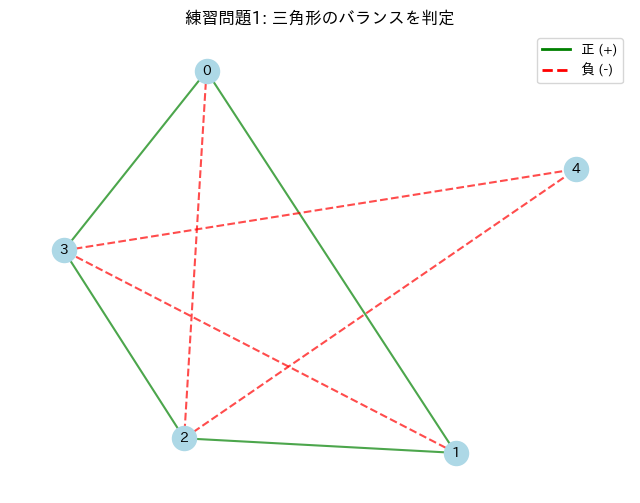

In [10]:
# 練習用ネットワーク
G_prob1 = nx.Graph()
edges = [
    (0, 1, 1), (1, 2, 1), (2, 0, -1),  # 三角形1
    (2, 3, 1), (3, 4, -1), (4, 2, -1), # 三角形2
    (0, 3, 1), (1, 3, -1)              # 追加エッジ
]
for u, v, sign in edges:
    G_prob1.add_edge(u, v, sign=sign)

# ネットワークを表示
fig, ax = plt.subplots(figsize=(8, 6))
draw_signed_network(G_prob1, ax, '練習問題1: 三角形のバランスを判定')
ax.plot([], [], 'g-', linewidth=2, label='正 (+)')
ax.plot([], [], 'r--', linewidth=2, label='負 (-)')
ax.legend()
plt.show()

# ここにコードを書いてください


<details>
<summary>解答例を見る</summary>

```python
def analyze_all_triangles(G):
    """すべての三角形を分析"""
    triangles = []
    
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                if G.has_edge(n1, n2):
                    # 重複を避けるため、ノードをソート
                    triangle = tuple(sorted([node, n1, n2]))
                    if triangle not in [t[0] for t in triangles]:
                        sign1 = G[triangle[0]][triangle[1]]['sign']
                        sign2 = G[triangle[1]][triangle[2]]['sign']
                        sign3 = G[triangle[0]][triangle[2]]['sign']
                        
                        product = sign1 * sign2 * sign3
                        is_balanced = product > 0
                        
                        triangles.append((triangle, (sign1, sign2, sign3), is_balanced))
    
    return triangles

triangles = analyze_all_triangles(G_prob1)

print("三角形の分析結果:")
for triangle, signs, is_balanced in triangles:
    sign_str = ''.join(['+' if s > 0 else '-' for s in signs])
    status = 'バランス' if is_balanced else '不均衡'
    print(f"  {triangle}: {sign_str} → {status}")

# バランス比率
n_balanced = sum(1 for _, _, b in triangles if b)
print(f"\nバランス比率: {n_balanced}/{len(triangles)} = {n_balanced/len(triangles):.1%}")
```
</details>

### 問題2: バランス化の最小変更

以下のネットワークを完全にバランスさせるために、最小限のエッジの符号を反転させてください。
どのエッジを反転すべきかを特定し、反転後のネットワークを可視化してください。

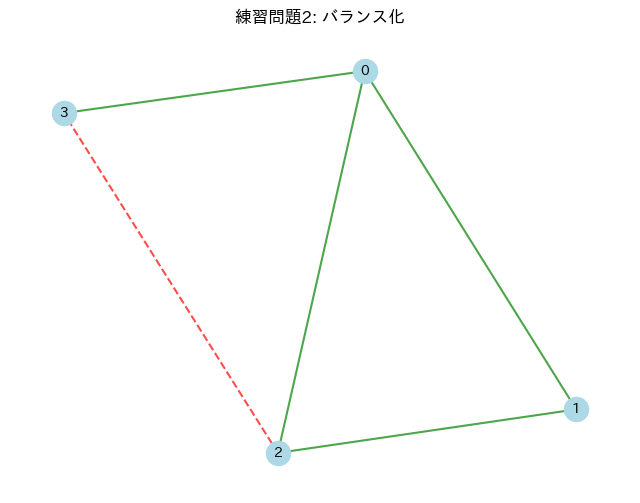

In [11]:
# 練習用ネットワーク（小さな例）
G_prob2 = nx.Graph()
G_prob2.add_edges_from([
    (0, 1, {'sign': 1}),
    (1, 2, {'sign': 1}),
    (2, 0, {'sign': 1}),
    (2, 3, {'sign': -1}),
    (0, 3, {'sign': 1}),  # この三角形は不均衡
])

fig, ax = plt.subplots(figsize=(8, 6))
draw_signed_network(G_prob2, ax, '練習問題2: バランス化')
plt.show()

# ここにコードを書いてください


<details>
<summary>解答例を見る</summary>

```python
# 現在のバランス状態を確認
balanced, unbalanced, details = count_triangles_by_balance(G_prob2)
print(f"現在の状態: バランス={balanced}, 不均衡={unbalanced}")

# 不均衡な三角形を特定
for node in G_prob2.nodes():
    neighbors = list(G_prob2.neighbors(node))
    for i, n1 in enumerate(neighbors):
        for n2 in neighbors[i+1:]:
            if G_prob2.has_edge(n1, n2):
                sign1 = G_prob2[node][n1]['sign']
                sign2 = G_prob2[node][n2]['sign']
                sign3 = G_prob2[n1][n2]['sign']
                product = sign1 * sign2 * sign3
                
                if product < 0:
                    print(f"不均衡な三角形: ({node}, {n1}, {n2})")
                    print(f"  エッジ ({node},{n1}): {'+' if sign1 > 0 else '-'}")
                    print(f"  エッジ ({node},{n2}): {'+' if sign2 > 0 else '-'}")
                    print(f"  エッジ ({n1},{n2}): {'+' if sign3 > 0 else '-'}")

# 解決策：(0,3)を-に変更、または(2,3)を+に変更
# (2,3)を+に変更する方がバランス
G_fixed = G_prob2.copy()
G_fixed[2][3]['sign'] = 1  # -から+に変更

print(f"\n修正: エッジ(2,3)の符号を-から+に変更")

# 修正後の確認
balanced_new, unbalanced_new, _ = count_triangles_by_balance(G_fixed)
print(f"修正後: バランス={balanced_new}, 不均衡={unbalanced_new}")

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
draw_signed_network(G_prob2, axes[0], '修正前')
draw_signed_network(G_fixed, axes[1], '修正後（完全バランス）')
plt.tight_layout()
plt.show()
```
</details>

### 問題3: バランス化ダイナミクスの比較

異なる初期条件（正のエッジの割合: 0.3, 0.5, 0.7）でネットワークを生成し、
バランス化ダイナミクスの収束速度を比較してください。

In [12]:
# ここにコードを書いてください


<details>
<summary>解答例を見る</summary>

```python
p_positive_values = [0.3, 0.5, 0.7]
n_trials = 10
max_steps = 200

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['red', 'blue', 'green']

for p_pos, color in zip(p_positive_values, colors):
    all_histories = []
    
    for trial in range(n_trials):
        G = create_signed_network(20, p_edge=0.4, p_positive=p_pos, seed=trial)
        _, history = balance_dynamics(G, max_steps=max_steps, p_flip=0.3)
        all_histories.append(history)
    
    # 平均を計算
    max_len = max(len(h) for h in all_histories)
    padded = [h + [h[-1]] * (max_len - len(h)) for h in all_histories]
    mean_history = np.mean(padded, axis=0)
    std_history = np.std(padded, axis=0)
    
    ax.plot(range(len(mean_history)), mean_history, color=color,
            linewidth=2, label=f'p_positive={p_pos}')
    ax.fill_between(range(len(mean_history)),
                    mean_history - std_history,
                    mean_history + std_history,
                    alpha=0.2, color=color)

ax.set_xlabel('ステップ', fontsize=12)
ax.set_ylabel('バランス比率', fontsize=12)
ax.set_title('正のエッジ割合とバランス化ダイナミクス', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

print("考察:")
print("  正のエッジが多いほど初期バランス比率が高い傾向")
print("  どの条件でも時間とともにバランスに収束")
```
</details>

---

## 参考文献

1. Heider, F. (1946). Attitudes and cognitive organization. The Journal of Psychology, 21(1), 107-112.

2. Cartwright, D., & Harary, F. (1956). Structural balance: a generalization of Heider's theory. Psychological Review, 63(5), 277.

3. Leskovec, J., Huttenlocher, D., & Kleinberg, J. (2010). Predicting positive and negative links in online social networks. WWW '10.

4. Easley, D., & Kleinberg, J. (2010). Networks, Crowds, and Markets. Cambridge University Press. Chapter 5.